# (Try to) identify signals of gentrification from Airbnb data

In [79]:
import os
import re
import pandas as pd
import numpy as np
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
from scipy.stats import zscore, gaussian_kde
import matplotlib.patches as mpatches
import matplotlib.colors as colors
from datetime import datetime
import seaborn as sns
from shapely.geometry import Point
from geopandas import GeoDataFrame
from IPython.core.pylabtools import figsize
from fontTools.varLib.interpolatableHelpers import matching_for_vectors
import folium
import branca.colormap as cm
from sklearn.preprocessing import StandardScaler
import sys

sys.path.insert(0, '../')
from PlottingFunctions import *

cmap = plt.get_cmap('viridis', 5)  # 5 discrete colors
plot_colors = [cmap(i) for i in range(5)]
plot_colors[4] = 'gold'

city='manchester'

### Get just Manchester LSOAs

In [2]:
lsoas =  gpd.read_file('../../../data/SpatialData/LSOAs_2011/LSOA_2011_EW_BSC_V4.shp')
manc_lads = ['Manchester', 'Rochdale', 'Bolton', 'Bury', 'Wigan', 'Oldham',  'Trafford', 'Salford', 'Tameside', 'Stockport']
manc_lads_pattern = '|'.join(manc_lads)
manchester_lsoas=lsoas[lsoas['LSOA11NMW'].str.contains(manc_lads_pattern)]

In [3]:
manchester_lsoas = manchester_lsoas.to_crs(epsg=27700)

# Define Manchester city centre point (in WGS84, then project)
city_centre_wgs84 = Point(-2.2426, 53.4808)  # approx lat/lon of Manchester city centre
city_centre_point = gpd.GeoSeries([city_centre_wgs84], crs='EPSG:4326').to_crs(epsg=27700).iloc[0]

# Filter polygons within a buffer distance (e.g., 3 km radius)
buffer = city_centre_point.buffer(6000)  # 3000 meters
central_lsoas = manchester_lsoas[manchester_lsoas.intersects(buffer)]
central_lsoas.reset_index(inplace=True)

## Get gentrification scores for each listing

In [88]:
base_dir = os.path.expanduser(f"../../../data/AirbnbData/airbnb-{city}/")
score_per_listing = pd.read_csv(base_dir + 'airbnb_gentrification_scores_categorical_combined_listings_filtered_01.csv')

mapping = {'Na': 0,'Undeveloped': 1, 'Emerging': 2, 'Gentrifying': 3, 'Established': 4}
score_per_listing['gentrification_prediction_code'] = score_per_listing['gentrification_prediction'].map(mapping)
# Remove rows with an error
score_per_listing = score_per_listing[score_per_listing['explanation'] != 'ERROR']
score_per_listing = score_per_listing[["LSOA11NM", 'gentrification_prediction', 'explanation', 'gentrification_prediction_code', 'longitude',
                                              'latitude']]
score_per_listing['gentrification_prediction_code'] = score_per_listing['gentrification_prediction_code'].astype(int)
score_per_listing.head()

,LSOA11NM,gentrification_prediction,explanation,gentrification_prediction_code,longitude,latitude
0,Salford 016B,Emerging,The neighborhood description mentions a public...,2,-2.262490,53.501530
1,Manchester 055D,Na,The text is too sparse to make any assessment.,0,-2.229190,53.484110
2,Manchester 057A,Established,The listing highlights Manchester City Centre'...,4,-2.244034,53.468518
3,Manchester 055E,Gentrifying,"The description of New Islington as a ""real ne...",3,-2.223740,53.480980
4,Manchester 029D,Gentrifying,"Chorlton is described as ""vibrant"" and ""bohemi...",3,-2.277860,53.445530


### Convert to geodataframe of scores per listing, reproject to BNG

In [5]:
score_per_listing['geometry'] = score_per_listing.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
score_per_listing_gdf = gpd.GeoDataFrame(score_per_listing, geometry='geometry', crs="EPSG:4326")
score_per_listing_gdf = score_per_listing_gdf.set_crs(epsg=4326, allow_override=True)
score_per_listing_gdf = score_per_listing_gdf.to_crs(epsg=27700)
score_per_listing_gdf.head()

,LSOA11NM,gentrification_prediction,explanation,gentrification_prediction_code,longitude,latitude,geometry
0,Salford 016B,Emerging,The neighborhood description mentions a public...,2.0,-2.262490,53.501530,POINT (382685.95 400569.291)
1,Manchester 055D,Na,The text is too sparse to make any assessment.,0.0,-2.229190,53.484110,POINT (384888.564 398623.618)
2,Manchester 057A,Established,The listing highlights Manchester City Centre'...,4.0,-2.244034,53.468518,POINT (383897.612 396892.234)
3,Manchester 055E,Gentrifying,"The description of New Islington as a ""real ne...",3.0,-2.223740,53.480980,POINT (385249.127 398274.243)
4,Manchester 029D,Gentrifying,"Chorlton is described as ""vibrant"" and ""bohemi...",3.0,-2.277860,53.445530,POINT (381642.127 394342.959)


### Find which LSOA each listing is within

In [6]:
score_per_listing_with_lsoa = gpd.sjoin(
    score_per_listing_gdf,
    central_lsoas[['LSOA11NM', 'geometry']],
    how='right',
    predicate='within')

del score_per_listing_with_lsoa['LSOA11NM_left']
score_per_listing_with_lsoa.rename(columns = {'LSOA11NM_right':'LSOA11NM'}, inplace=True)
score_per_listing_with_lsoa.reset_index(inplace=True, drop=True)
score_per_listing_with_lsoa.head()

,index_left,gentrification_prediction,explanation,gentrification_prediction_code,longitude,latitude,LSOA11NM,geometry
0,756.0,Established,"The mention of Heaton Park, a major municipal ...",4.0,-2.273020,53.531710,Bury 023C,"POLYGON ((382461.689 403765.502, 382238.998 40..."
1,1771.0,Gentrifying,"The location in Prestwich, with its metro link...",3.0,-2.269601,53.532356,Bury 023C,"POLYGON ((382461.689 403765.502, 382238.998 40..."
2,1946.0,Gentrifying,The neighborhood is described as charming with...,3.0,-2.269350,53.532790,Bury 023C,"POLYGON ((382461.689 403765.502, 382238.998 40..."
3,3101.0,Emerging,"The listing mentions independent restaurants, ...",2.0,-2.271682,53.532365,Bury 023C,"POLYGON ((382461.689 403765.502, 382238.998 40..."
4,4523.0,Established,"The mention of Heaton Park, a well-known publi...",4.0,-2.268370,53.534400,Bury 023C,"POLYGON ((382461.689 403765.502, 382238.998 40..."


### Check this spatially

## Create a dataframe with a count of the number of listings in each LSOA, and the modal score

In [28]:
def dominant_and_percentage_and_count(x):
    mode_vals = pd.Series.mode(x)
    if mode_vals.empty:
        mode_val = None
        pct = 0.0
    else:
        mode_val = mode_vals.iloc[0]
        pct = (x == mode_val).mean() * 100
    count = pd.Series.count(x)
    return pd.Series({'dominant_class': mode_val, 'dominant_pct': pct, 'count': count})
    
per_LSOA_summary = (
    score_per_listing_with_lsoa
    .groupby("LSOA11NM")["gentrification_prediction_code"]
    .apply(dominant_and_percentage_and_count)
    .unstack()
    .reset_index())

per_LSOA_summary = central_lsoas[['LSOA11NM', 'geometry']].merge(per_LSOA_summary, on='LSOA11NM')
per_LSOA_summary = per_LSOA_summary[per_LSOA_summary['dominant_class'].notnull()]
per_LSOA_summary['dominant_class'] = per_LSOA_summary['dominant_class'].astype(int)

In [100]:
colors = [cmap(i) for i in range(5)]
color_map = dict(zip(range(5), colors))
score_per_listing_gdf['color']= score_per_listing_gdf['gentrification_prediction_code'].map(color_map)

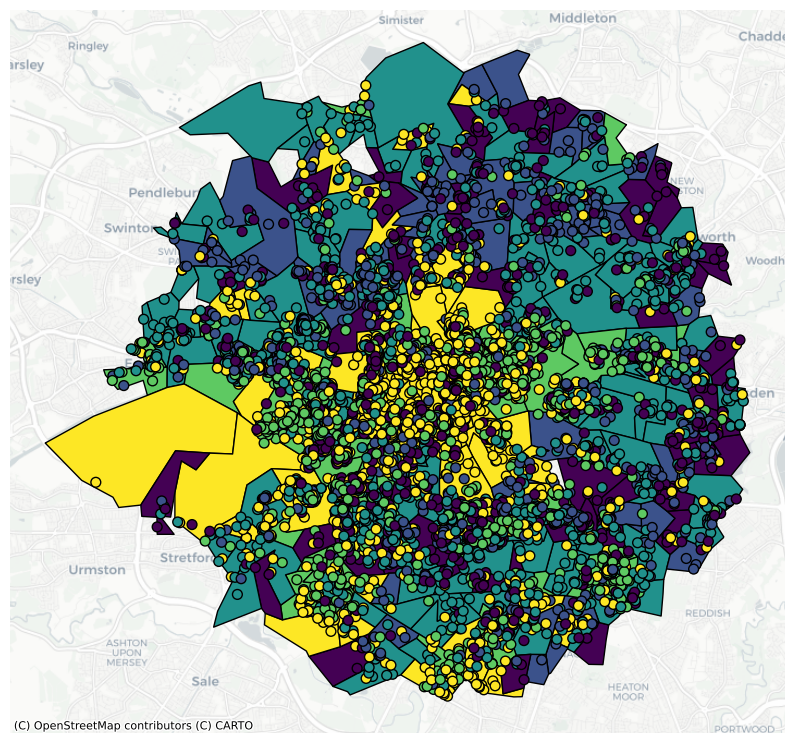

In [112]:
per_LSOA_summary['color'] = per_LSOA_summary['dominant_class'].map(cmap)
colors = [cmap(i) for i in range(5)]
color_map = dict(zip(range(5), colors))
score_per_listing_gdf['color']= score_per_listing_gdf['gentrification_prediction_code'].map(color_map)

fig,ax=plt.subplots(figsize=(10,10))

# Plot using the 'color' column directly
per_LSOA_summary_wm = per_LSOA_summary.to_crs(epsg=3857)
per_LSOA_summary_wm.plot(color=per_LSOA_summary_wm['color'], alpha=1, ax=ax, edgecolor='black')

score_per_listing_gdf_wm = score_per_listing_gdf.to_crs(epsg=3857)
score_per_listing_gdf_wm.plot(color=score_per_listing_gdf_wm['color'], ax=ax, legend=True, alpha=1, edgecolor='black', markersize=50);

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=score_per_listing_with_lsoa_wm.crs)

ax.axis("off");

## Plot

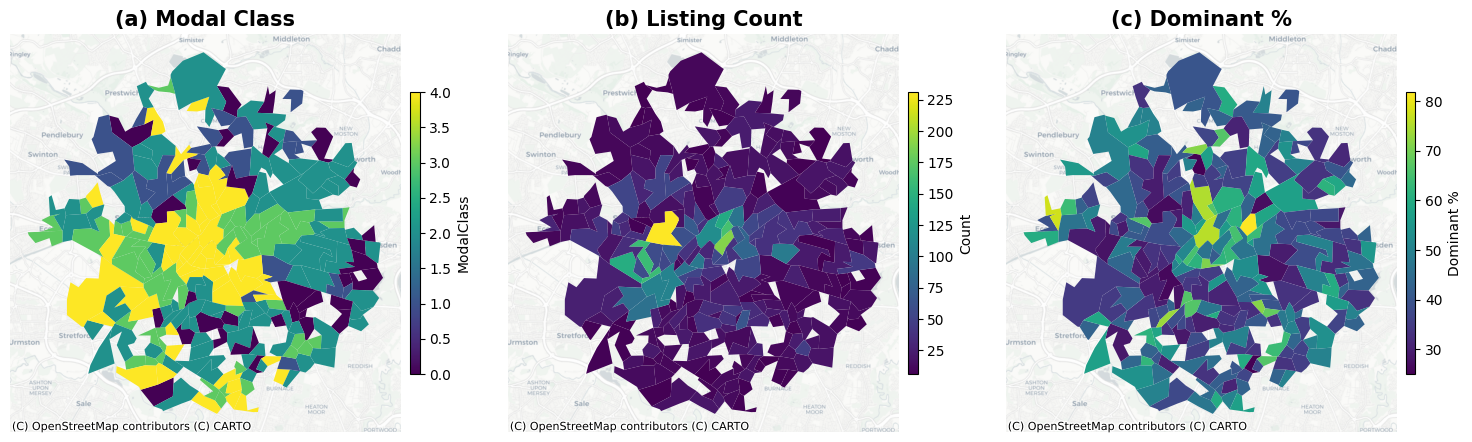

In [116]:
fig, axs = plt.subplots(ncols=3, figsize=(15, 5))  # wider but flatter

# Ensure CRS is web mercator for basemap
per_LSOA_summary = per_LSOA_summary.to_crs(epsg=3857)

# Common legend keyword settings
legend_opts = {
    "shrink": 0.6,
    "orientation": "vertical",
    "pad": 0.02,
    "aspect": 30}

# Second plot: dominant class
per_LSOA_summary_fitlered.plot(
    "dominant_class", alpha=1, ax=axs[0], legend=True,
    legend_kwds={"label": "ModalClass", **legend_opts})
ctx.add_basemap(axs[0], source=ctx.providers.CartoDB.Positron, crs=per_LSOA_summary.crs)
axs[0].set_title("(a) Modal Class", fontweight='bold', fontsize=15)

# First plot: count
per_LSOA_summary_fitlered.plot(
    "count", alpha=1, ax=axs[1], legend=True,
    legend_kwds={"label": "Count", **legend_opts})
ctx.add_basemap(axs[1], source=ctx.providers.CartoDB.Positron, crs=per_LSOA_summary.crs)
axs[1].set_title("(b) Listing Count", fontweight='bold', fontsize=15)

# Third plot: dominant percent
per_LSOA_summary_fitlered.plot(
    "dominant_pct", alpha=1, ax=axs[2], legend=True,
    legend_kwds={"label": "Dominant %", **legend_opts})
ctx.add_basemap(axs[2], source=ctx.providers.CartoDB.Positron, crs=per_LSOA_summary.crs)
axs[2].set_title("(c) Dominant %", fontweight='bold', fontsize=15)

# Tidy up
for ax in axs:
    ax.axis('off')

plt.tight_layout()
plt.show()


### Gentrification index spatial plot

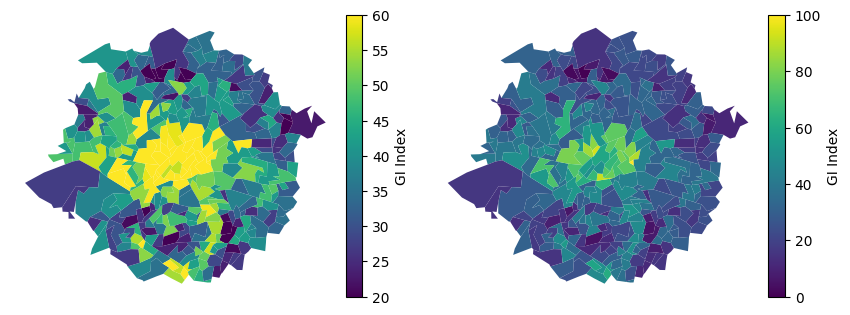

In [73]:
fig, axs = plt.subplots(ncols = 2, figsize=(10, 10), sharey=True, sharex=True)

# Plot the data
g_index.plot(column='gi_n',cmap='viridis',vmin=20,vmax=60,ax=axs[0],legend=False)

# Create divider and color axis
divider = make_axes_locatable(axs[0])
cax = divider.append_axes("right", size="5%", pad=0.05)

# Create ScalarMappable for colorbar
norm = colors.Normalize(vmin=20, vmax=60)
sm = cm.ScalarMappable(cmap='viridis', norm=norm)
sm._A = []  # dummy array

# Add colorbar
cbar = plt.colorbar(sm, cax=cax)
cbar.set_label("GI Index")

########### axis2
g_index.plot('gi_n', ax=axs[1])

# Create divider and color axis
divider = make_axes_locatable(axs[1])
cax = divider.append_axes("right", size="5%", pad=0.05)

# Create ScalarMappable for colorbar
norm = colors.Normalize(vmin=0, vmax=100)
sm = cm.ScalarMappable(cmap='viridis', norm=norm)
sm._A = []  # dummy array
# Add colorbar
cbar = plt.colorbar(sm, cax=cax)
cbar.set_label("GI Index")

axs[0].axis("off")
axs[1].axis("off");